<a href="https://colab.research.google.com/github/MagdaPla/UNET_PPM/blob/master/unet_ppm_mpla_copiaG_uoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DETECCIÓ DE ZONES AFECTADES PER PROCESSIONÀRIA A PARTIR D'IMATGES DRON I DEEP LEARNING (UNET)

In [0]:
system("sudo apt-get update")
system("sudo apt-get install -y libmagick++-dev")

install.packages("magick")
install.packages("keras")
install.packages("tfdatasets")
install.packages("tidyverse")
install.packages("rsample")
install.packages("reticulate")
install.packages("tibble")
install.packages("here")

In [1]:
library(magick)
library(keras)
library(tfdatasets)
library(tidyverse)
library(rsample)
library(reticulate)
library(tibble)
library(here)

Linking to ImageMagick 6.9.7.4
Enabled features: fontconfig, freetype, fftw, lcms, pango, x11
Disabled features: cairo, ghostscript, rsvg, webp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /content



In [0]:
# per a fer el procés reproduïble
tf<-tf$compat.v1
tf$set_random_seed(100)

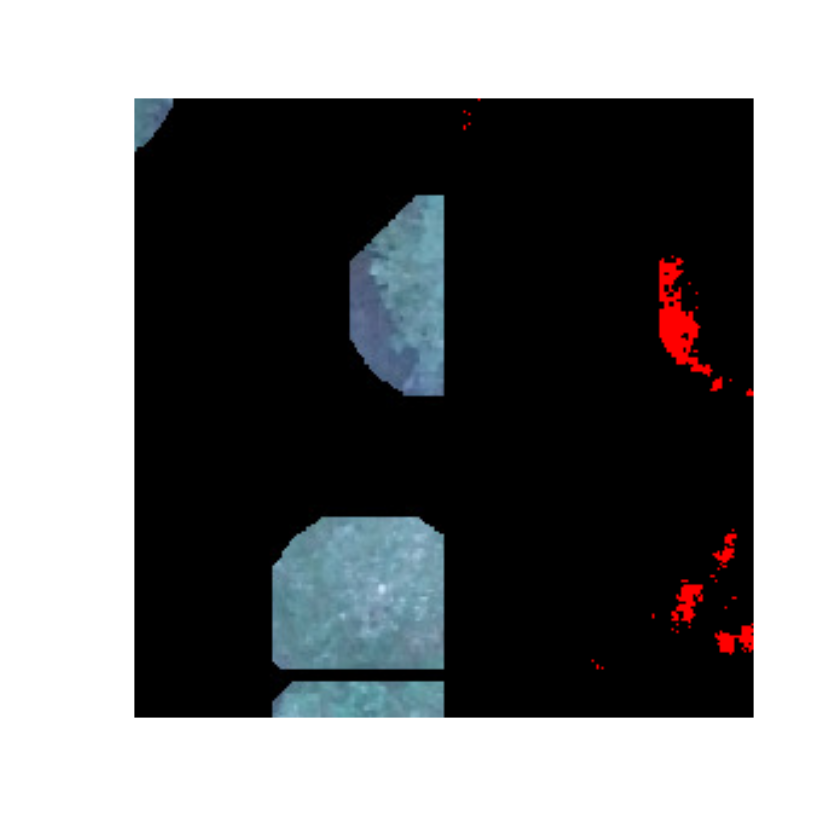

In [13]:
images <- tibble(
  img = list.files(here::here("sample_data/rgb1"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc1"), full.names = TRUE)
  ) %>% 
  sample_n(2) %>% 
  map(. %>% magick::image_read() %>% magick::image_resize("128x128"))

out <- magick::image_append(c(
  magick::image_append(images$img, stack = TRUE), 
  magick::image_append(images$mask, stack = TRUE)
  )
)

plot(out)

In [0]:
#Comencem a construïr el model. 
# Utilitzem `tfdatasets` per a carregar les dades i preparar el "pipeline"

data <- tibble(
  img = list.files(here::here("sample_data/rgb1"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc1"), full.names = TRUE)
)

data <- initial_split(data, prop = 0.8)

In [0]:
#definim el "pipeline" per llegir els fitxers i decodificar les iamtges to read the files and decode them as images. 
# en aquest cas les tenim com a RGB en `.jpeg` i màscares en `.gif`.
# no es sap decodificar els tiff, no existeix decode_tif... així que hem transformat a jpg i gif
training_dataset <- training(data) %>%  
  tensor_slices_dataset()%>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
    mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
  ))

In [0]:
#per veure els outputs de manera interactiva, utilitzarem:
example <- training_dataset %>% as_iterator() %>% iter_next()

In [0]:
#Carreguem les imatges en un tensor `float32` 
#amb valors entre [0,1]:
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
    mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
  ))

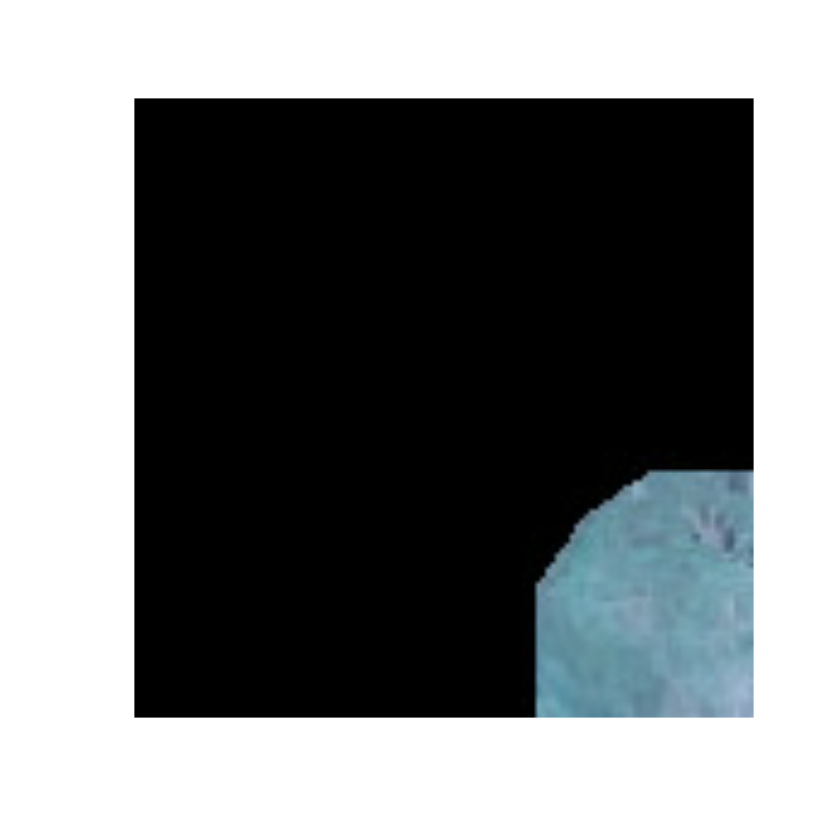

In [23]:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
# fem un procés senzill d'"augment" de les imatges
random_bsh <- function(img) {
  img %>% 
    tf$image$random_brightness(max_delta = 0.3) %>% 
    tf$image$random_contrast(lower = 0.5, upper = 0.7) %>% 
    tf$image$random_saturation(lower = 0.5, upper = 0.7) %>% 
    tf$clip_by_value(0, 1) # clip the values into [0,1] range.
}

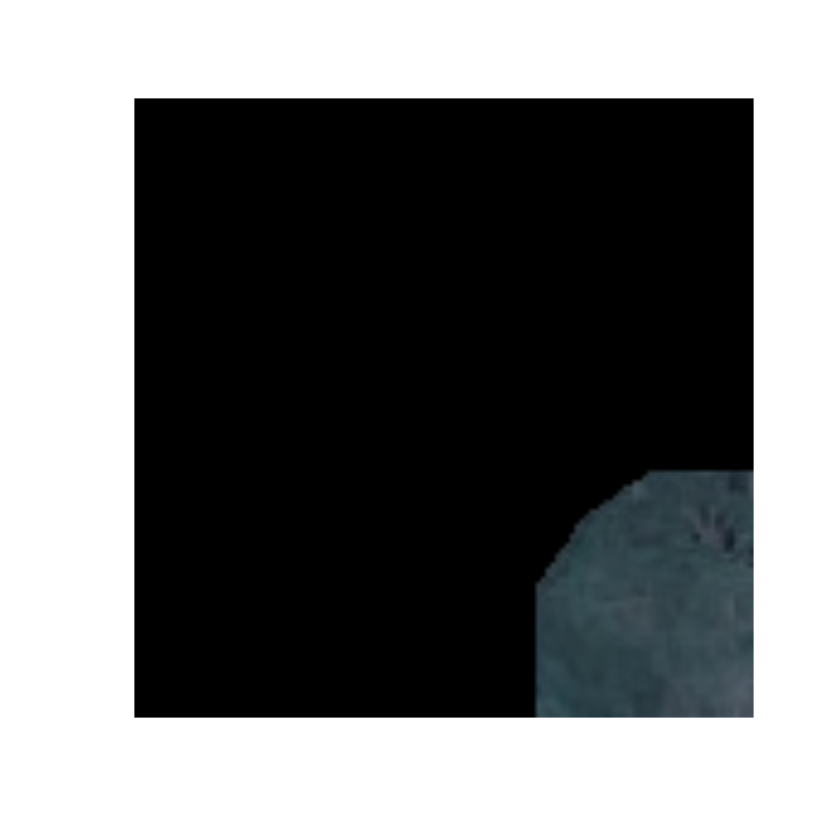

In [25]:
# veiem els efectes sobre les imatges corresponents 
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = random_bsh(.x$img)
  ))
# plot:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
#creem una funció amb el codi anterior i alhora
#creem el dataset de validació:

create_dataset <- function(data, train, batch_size = 32L) {
  
  dataset <- data %>% 
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
      mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
      mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
    ))
  
  if (train) {
    dataset <- dataset %>% 
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      )) 
  }
  
  if (train) {
    dataset <- dataset %>% 
      dataset_shuffle(buffer_size = batch_size*128)
  }
  
  dataset <- dataset %>% 
    dataset_batch(batch_size)
    
  dataset %>% 
    dataset_map(unname) # Keras needs an unnamed output.
}

In [27]:
data

<Training/Validation/Total>
<114/28/142>

In [0]:
# Creem propiament les dades d'entrenament i les de validació:
training_dataset <- create_dataset(training(data), train = TRUE)
validation_dataset <- create_dataset(testing(data), train = FALSE)

In [0]:
# above, we have prepared our data pipeline. Now we need to build the model, 
# using the model of forest segmentation paper (Wagner et al)

# Primer calculem la mètrica i "loss" de manera personalitzada: 
# mirar però si em convé més utilitzar "binari crosentropy" o aquest... valoro

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

# per calcular el paràmetre "loss" segons Wagner et al,
# valoro si cal posar-la o no, de moment he utilitzat la BinaryCrossentropy
# bce_dice_loss <- function(y_true, y_pred) {
#  result <- loss_binary_crossentropy(y_true, y_pred) +
#    (1 - dice_coef(y_true, y_pred))
#  return(result)
#}

In [30]:
# the model, and the compilation of the model:
model <- keras_model_sequential()

get_unet_128 <- function(input_shape = c(128, 128, 3),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            activation = "sigmoid")
  
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = "BinaryCrossentropy",
    metrics = c(dice_coef)
  )
  
  return(model)
}

model <- get_unet_128()
summary(model)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      [(None, 128, 128, 0                                   
________________________________________________________________________________
conv2d (Conv2D)           (None, 128, 128,  1792     input_1[0][0]              
________________________________________________________________________________
batch_normalization (Batc (None, 128, 128,  256      conv2d[0][0]               
________________________________________________________________________________
activation (Activation)   (None, 128, 128,  0        batch_normalization[0][0]  
________________________________________________________________________________
conv2d_1 (Conv2D)         (None, 128, 128,  36928    activation[0][0]           
________________________________________________________________________________
batch_normali

In [0]:
checkpoint_path <- "weights_r/cp.ckpt"

# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = checkpoint_path,
  save_weights_only = TRUE,
  save_best_only = TRUE,
  verbose = 1
)

history <- model %>% fit(
  training_dataset,
  epochs = 100,
  validation_data = validation_dataset, 
  callbacks = list(cp_callback), # pass callback to training,
  verbose= 2
)



`geom_smooth()` using formula 'y ~ x'



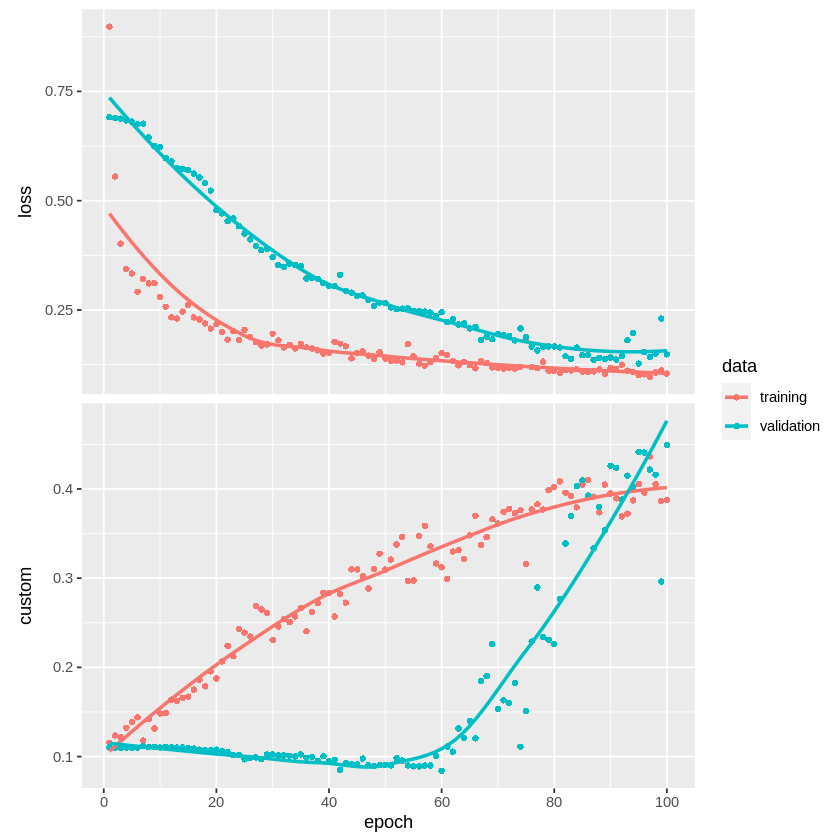

In [32]:
plot(history)

In [33]:
print(history)


Final epoch (plot to see history):
      loss: 0.1044
    custom: 0.3875
  val_loss: 0.1485
val_custom: 0.4492 


In [34]:
# evaluate accuracy on the validation dataset
model %>% evaluate(validation_dataset,verbose = 0)

loss    custom 
0.1485069 0.4492248

In [0]:
# per a veure les prediccions fetes
figures <- validation_dataset %>% as_iterator() %>% iter_next()
predictions <- predict(model, kk)

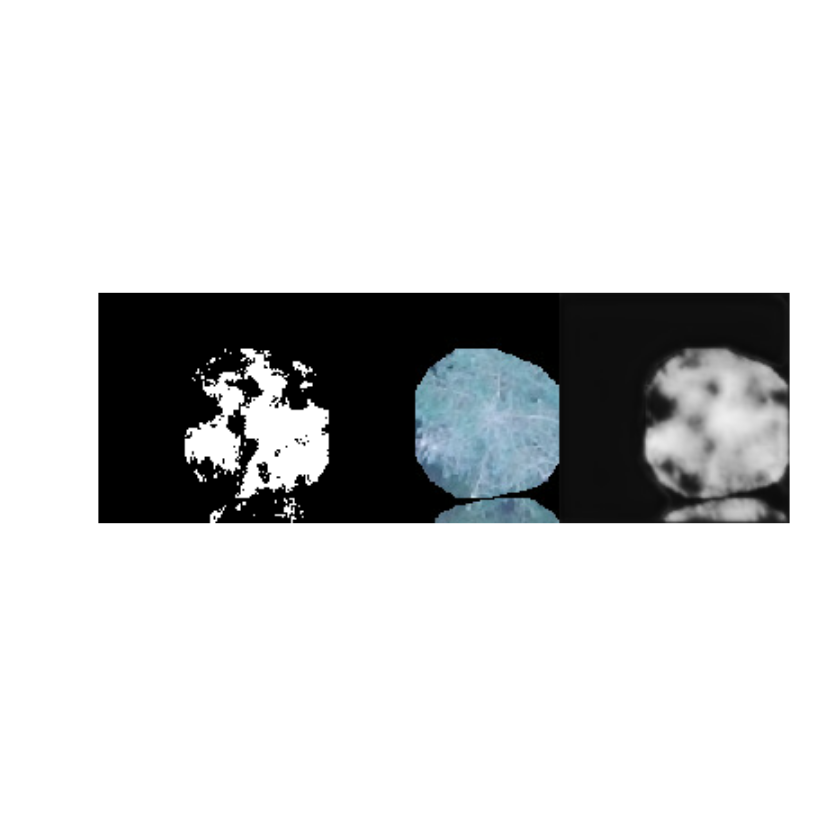

In [106]:
images <- tibble(
  image = figures[[1]] %>% array_branch(1),
  predicted_mask = predictions[,,,1] %>% array_branch(1),
  mask = figures[[2]][,,,1]  %>% array_branch(1)
) %>% 
  sample_n(1) %>% 
  map_depth(2, function(x) {
    as.raster(x) %>% magick::image_read()
  }) %>% 
  map(~do.call(c, .x))

# per a plotejar-ho en ordre:
out <- magick::image_append(c(
  magick::image_append(images$mask, stack = TRUE),
  magick::image_append(images$image, stack = TRUE), 
  magick::image_append(images$predicted_mask, stack = TRUE)
  )
)

plot(out)

In [0]:
# per a generar una predicció d'un altre dataset amb el mateix model:
# pujo les dades en el model (noves_dades) ---- em cal comprobar
noves_segmentacions<-model %>% predict(noves_dades)